# German Traffic Sign Recognition Classifier

### Importing libraries

In [67]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from sklearn.utils import shuffle # for shuffling the training data
import cv2 # for grayscaling
from skimage.color import rgb2gray
from skimage import io # read in images from the web
from pandas.io.parsers import read_csv
import math
import scipy.ndimage
import pandas as pd
import os

## Step 0: Load The Data

In [68]:
print('Loading training metadata ...')

# Path to CSV
training_file = 'data_set/train_dataset.csv'

# Load the CSV file
train_df = pd.read_csv(training_file)

# Displaying basic info
print("✅ CSV loaded successfully!")
print(f"Total samples: {len(train_df)}")
print("Columns:", train_df.columns.tolist())

# Extracting individual columns for convenience
image_names = train_df['image_name'].tolist()
x1 = train_df['x1'].tolist()
y1 = train_df['y1'].tolist()
x2 = train_df['x2'].tolist()
y2 = train_df['y2'].tolist()
widths = train_df['width'].tolist()
heights = train_df['height'].tolist()
y_train = train_df['label_id'].tolist()
label_names = train_df['label_name'].tolist()

print('✅ Training data loaded and parsed successfully.')
print(f"Example entry:\nImage: {image_names[0]}, Label: {label_names[0]}, Bounding box: ({x1[0]}, {y1[0]}, {x2[0]}, {y2[0]})")


Loading training metadata ...
✅ CSV loaded successfully!
Total samples: 4410
Columns: ['image_name', 'x1', 'y1', 'x2', 'y2', 'width', 'height', 'label_id', 'label_name']
✅ Training data loaded and parsed successfully.
Example entry:
Image: 0000.png, Label: End of no passing, Bounding box: (6, 5, 22, 20)


---

## Step 1: Dataset Summary & Visualization

### Summary of the original dataset

In [69]:
print("Loading training dataset summary ...")

# Load the CSV
training_file = 'data_set/train_dataset.csv'
train_df = pd.read_csv(training_file)

# Number of training examples
n_train = len(train_df)
print("Number of training samples =", n_train)

# Length of ground truth labels
y_train = train_df['label_id'].tolist()
n_train_y = len(y_train)
print("Length of ground truth labels =", n_train_y)

# Number of unique classes / labels
n_classes = train_df['label_id'].nunique()
print("Number of classes =", n_classes)

# Original shape (width x height) of last image in the dataset
last_width = train_df.iloc[-1]['width']
last_height = train_df.iloc[-1]['height']
print("Original Shape of the last image (width x height):", int(last_width), "x", int(last_height))

# Shape of one loaded image 
image_shape = (32, 32, 3)
print("Shape of the first image (after resizing):", image_shape)

# print unique label names for clarity
unique_labels = train_df['label_name'].unique()
print("\nUnique label names (first 10):", unique_labels[:10])


Loading training dataset summary ...
Number of training samples = 4410
Length of ground truth labels = 4410
Number of classes = 43
Original Shape of the last image (width x height): 151 x 136
Shape of the first image (after resizing): (32, 32, 3)

Unique label names (first 10): ['End of no passing' 'Wild animals crossing' 'Go straight or right'
 'Traffic signals' 'Slippery road' 'Speed Limit 30' 'Roundabout mandatory'
 'Bumpy road' 'Go straight or left' 'Vehicles >3.5t prohibited']


###  Visualization of the original dataset

Visualizing the German Traffic Signs Dataset.
Let's take a look on the training dataset. We will check each class (type of traffic sign), counting its number of samples and plotting 10 random images.

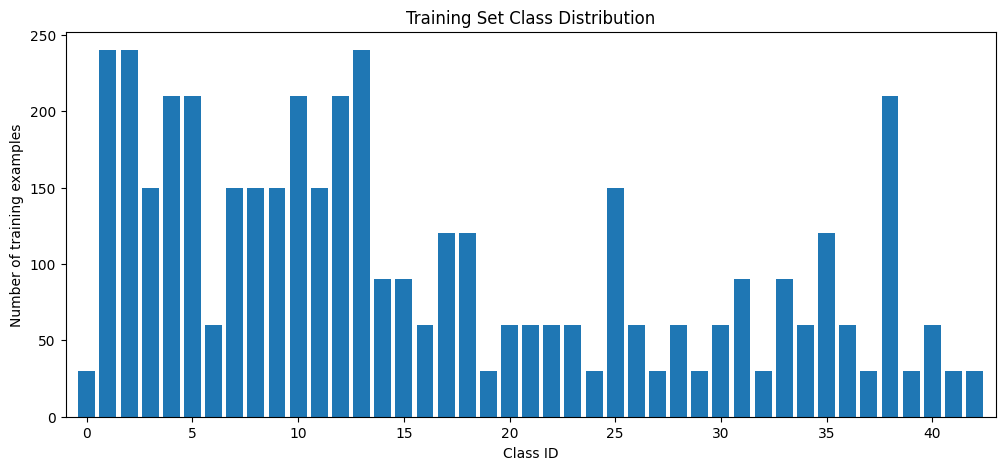

Class  0: Speed Limit 20                30 samples


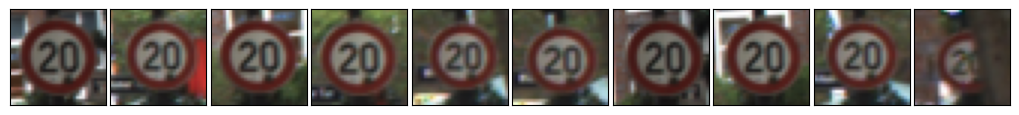

--------------------------------------------------------------------------------------

Class  1: Speed Limit 30                240 samples


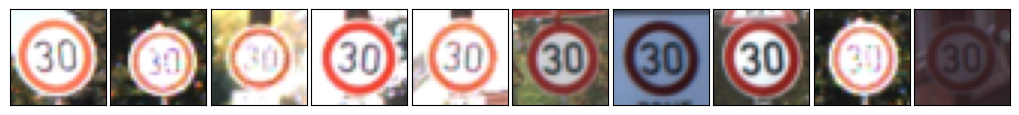

--------------------------------------------------------------------------------------

Class  2: Speed Limit 50                240 samples


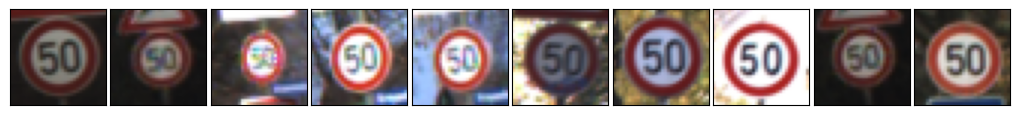

--------------------------------------------------------------------------------------

Class  3: Speed Limit 60                150 samples


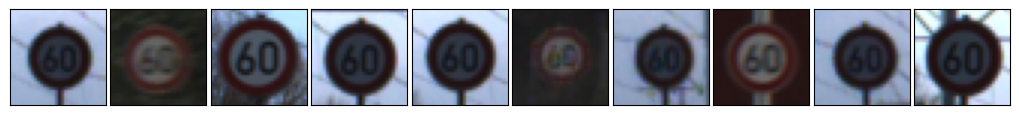

--------------------------------------------------------------------------------------

Class  4: Speed Limit 70                210 samples


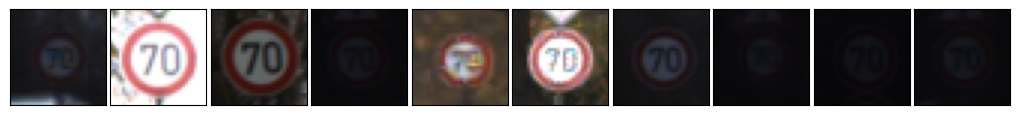

--------------------------------------------------------------------------------------

Class  5: Speed Limit 80                210 samples


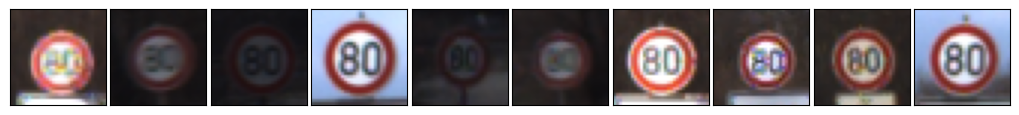

--------------------------------------------------------------------------------------

Class  6: End of Speed Limit 80         60 samples


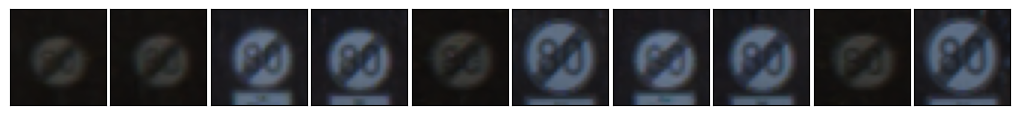

--------------------------------------------------------------------------------------

Class  7: Speed Limit 100               150 samples


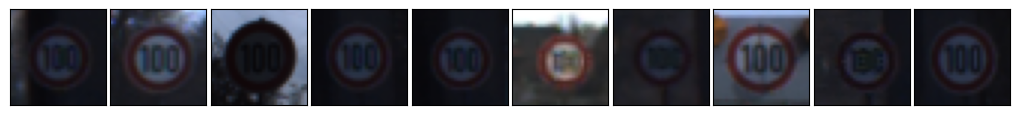

--------------------------------------------------------------------------------------

Class  8: Speed Limit 120               150 samples


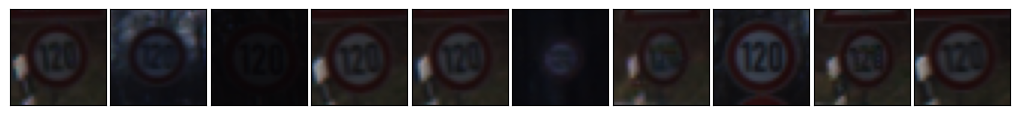

--------------------------------------------------------------------------------------

Class  9: No passing                    150 samples


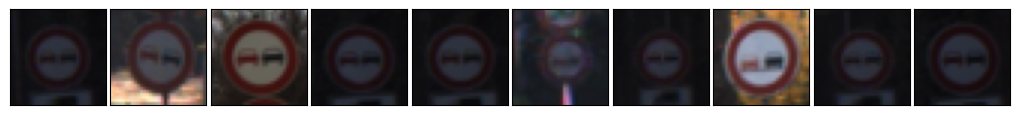

--------------------------------------------------------------------------------------

Class 10: No passing (trucks)           210 samples


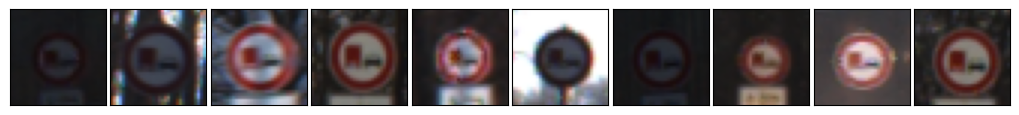

--------------------------------------------------------------------------------------

Class 11: Right-of-way at intersection  150 samples


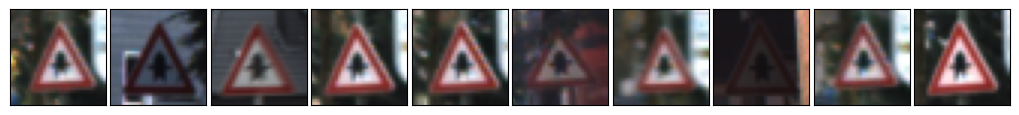

--------------------------------------------------------------------------------------

Class 12: Priority road                 210 samples


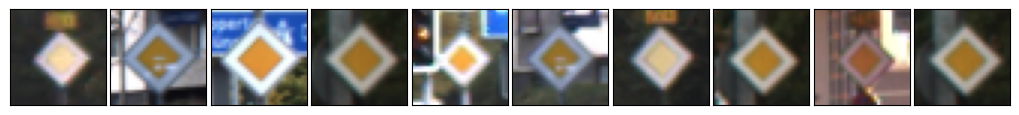

--------------------------------------------------------------------------------------

Class 13: Yield                         240 samples


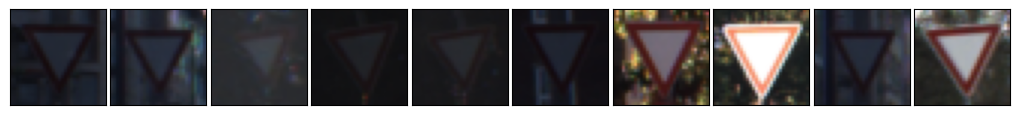

--------------------------------------------------------------------------------------

Class 14: Stop                          90 samples


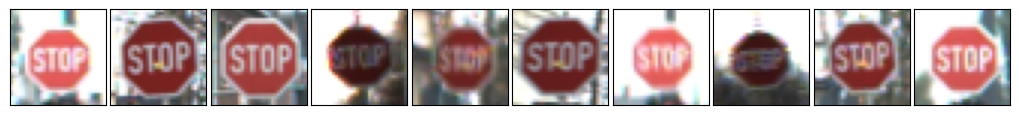

--------------------------------------------------------------------------------------

Class 15: No vehicles                   90 samples


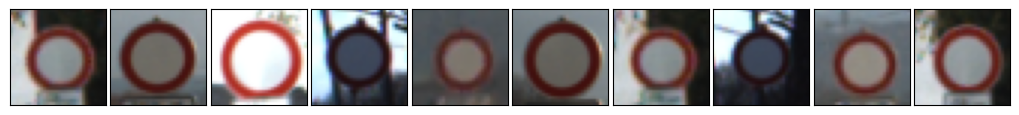

--------------------------------------------------------------------------------------

Class 16: Vehicles >3.5t prohibited     60 samples


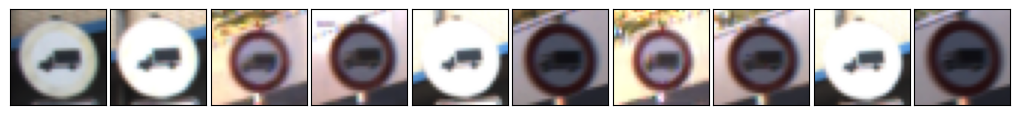

--------------------------------------------------------------------------------------

Class 17: No entry                      120 samples


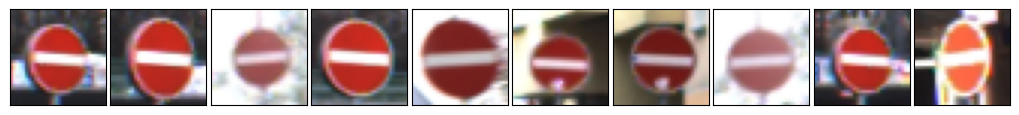

--------------------------------------------------------------------------------------

Class 18: General caution               120 samples


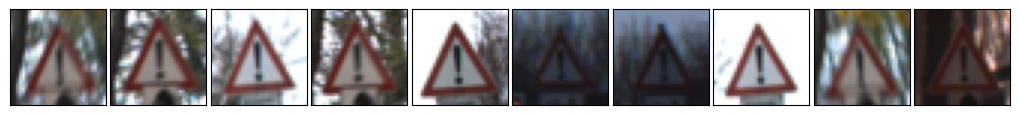

--------------------------------------------------------------------------------------

Class 19: Dangerous curve left          30 samples


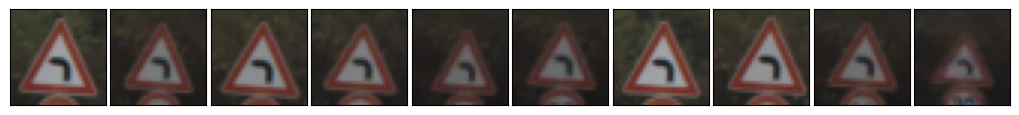

--------------------------------------------------------------------------------------

Class 20: Dangerous curve right         60 samples


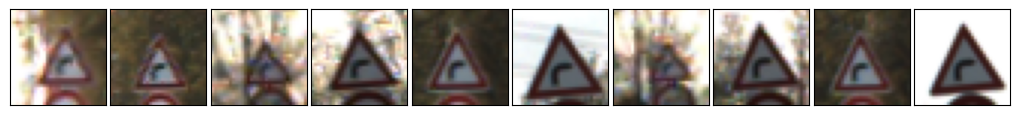

--------------------------------------------------------------------------------------

Class 21: Double curve                  60 samples


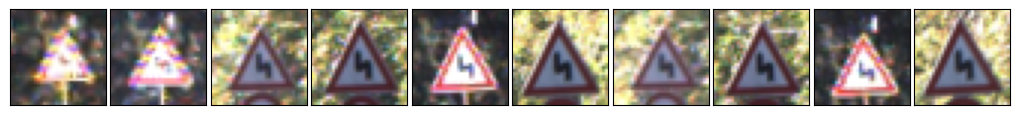

--------------------------------------------------------------------------------------

Class 22: Bumpy road                    60 samples


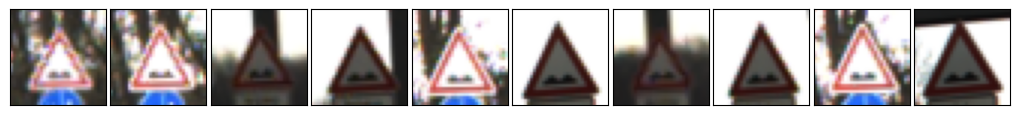

--------------------------------------------------------------------------------------

Class 23: Slippery road                 60 samples


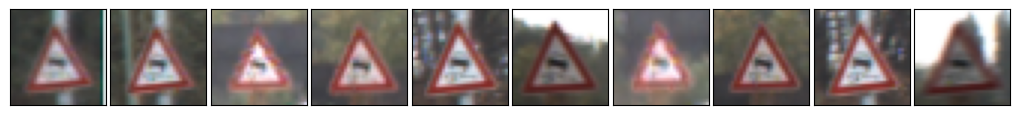

--------------------------------------------------------------------------------------

Class 24: Road narrows on right         30 samples


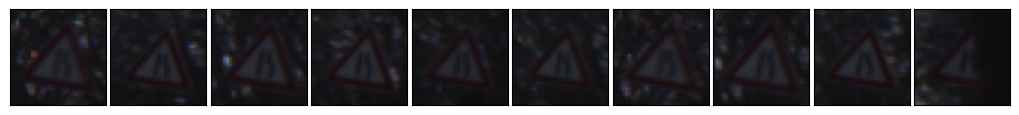

--------------------------------------------------------------------------------------

Class 25: Road work                     150 samples


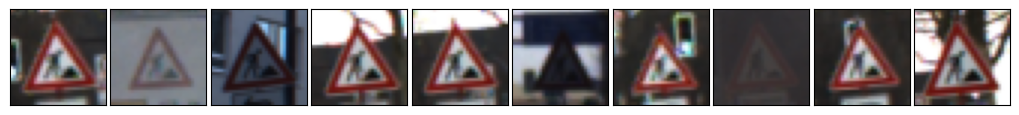

--------------------------------------------------------------------------------------

Class 26: Traffic signals               60 samples


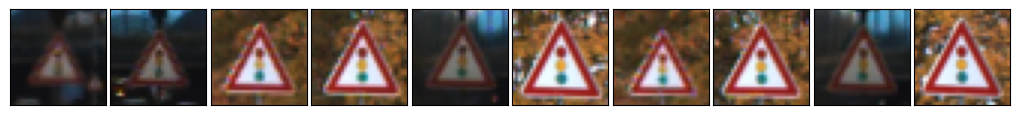

--------------------------------------------------------------------------------------

Class 27: Pedestrians                   30 samples


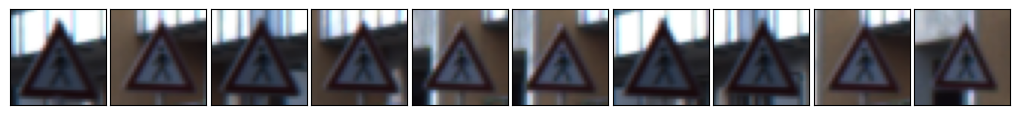

--------------------------------------------------------------------------------------

Class 28: Children crossing             60 samples


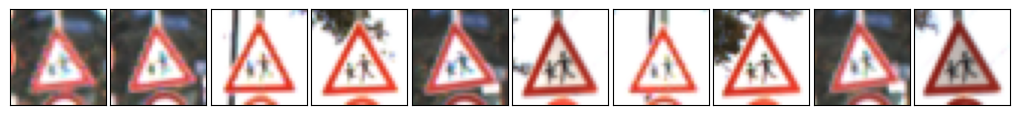

--------------------------------------------------------------------------------------

Class 29: Bicycles crossing             30 samples


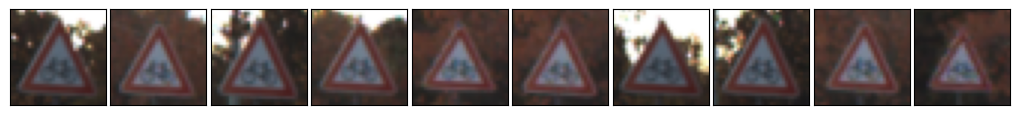

--------------------------------------------------------------------------------------

Class 30: Beware of ice/snow            60 samples


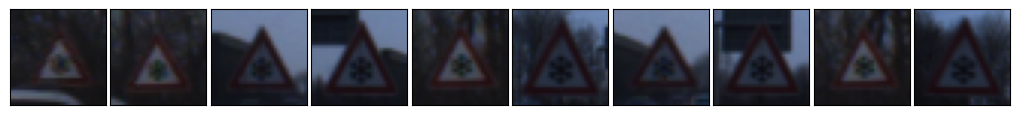

--------------------------------------------------------------------------------------

Class 31: Wild animals crossing         90 samples


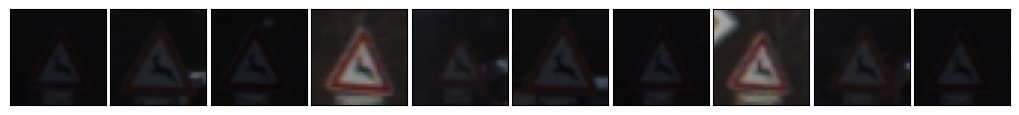

--------------------------------------------------------------------------------------

Class 32: End of restrictions           30 samples


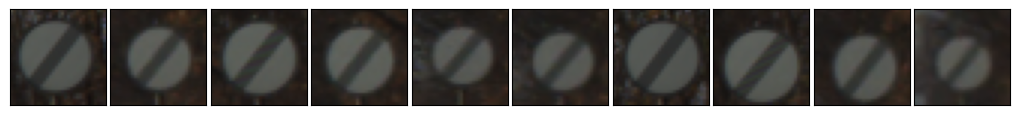

--------------------------------------------------------------------------------------

Class 33: Turn right ahead              90 samples


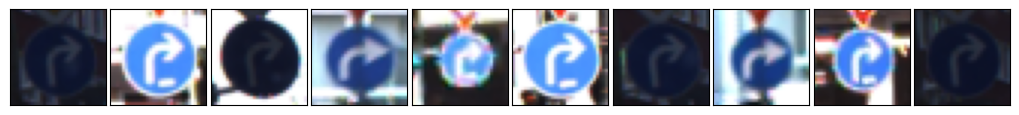

--------------------------------------------------------------------------------------

Class 34: Turn left ahead               60 samples


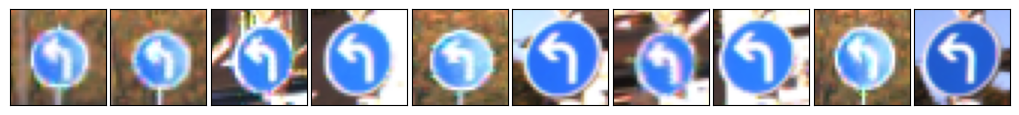

--------------------------------------------------------------------------------------

Class 35: Ahead only                    120 samples


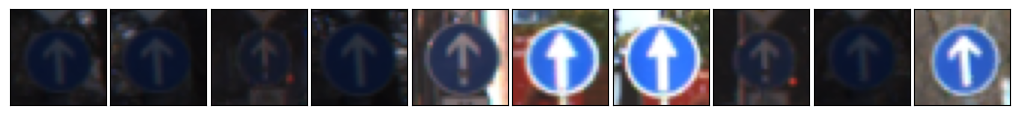

--------------------------------------------------------------------------------------

Class 36: Go straight or right          60 samples


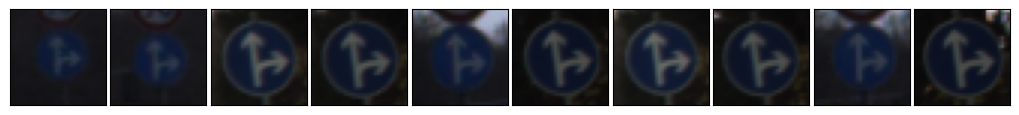

--------------------------------------------------------------------------------------

Class 37: Go straight or left           30 samples


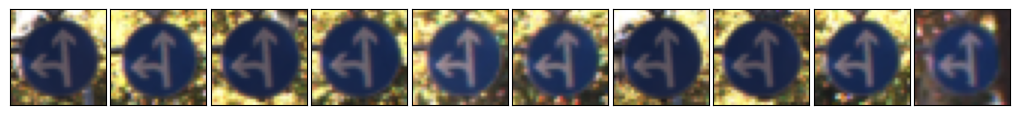

--------------------------------------------------------------------------------------

Class 38: Keep right                    210 samples


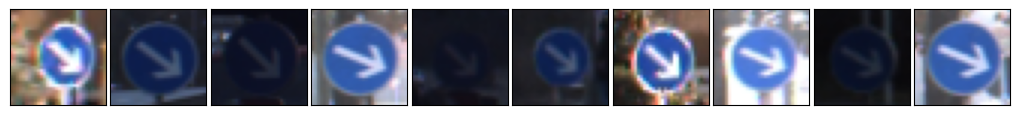

--------------------------------------------------------------------------------------

Class 39: Keep left                     30 samples


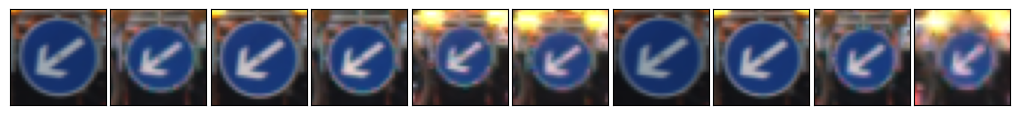

--------------------------------------------------------------------------------------

Class 40: Roundabout mandatory          60 samples


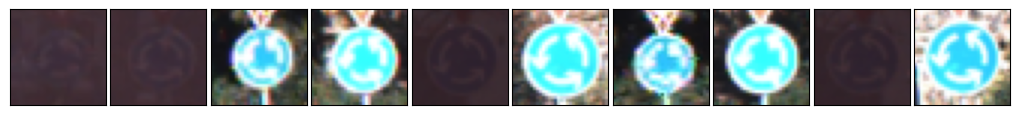

--------------------------------------------------------------------------------------

Class 41: End of no passing             30 samples


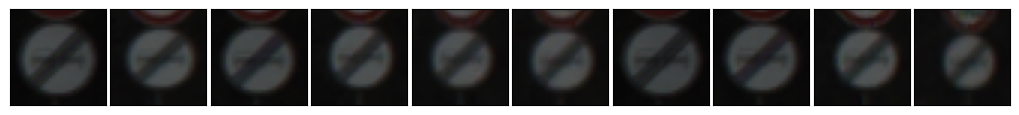

--------------------------------------------------------------------------------------

Class 42: End of no passing (trucks)    30 samples


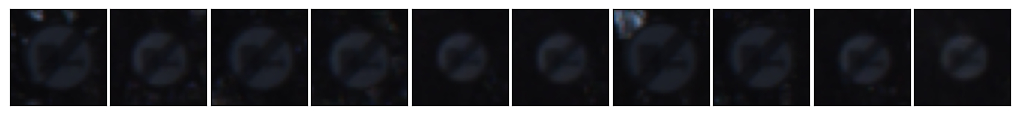

--------------------------------------------------------------------------------------



In [70]:
from PIL import Image
# ------------------------------------------------------------
# Load metadata
# ------------------------------------------------------------
train_df = pd.read_csv('data_set/train_dataset.csv')


image_folder = 'data_set/images'  

# ------------------------------------------------------------
# Prepare label info
# ------------------------------------------------------------
y_train = train_df['label_id'].values
signnames = train_df[['label_id', 'label_name']].drop_duplicates().sort_values(by='label_id')['label_name'].values

# Get unique classes and counts
sign_classes, class_counts = np.unique(y_train, return_counts=True)

# Bar plot for class distribution
plt.figure(figsize=(12, 5))
plt.bar(sign_classes, class_counts, align='center')
plt.xlabel('Class ID')
plt.ylabel('Number of training examples')
plt.title('Training Set Class Distribution')
plt.xlim([-1, max(sign_classes) + 1])
plt.show()

# ------------------------------------------------------------
# Show 10 random samples per class
# ------------------------------------------------------------
col_width = max(len(name) for name in signnames)

for c in sign_classes:
    class_name = signnames[c]
    class_subset = train_df[train_df['label_id'] == c]
    c_count = len(class_subset)

    print(f"Class {c:2d}: {class_name:<{col_width}}  {c_count} samples")

    # Plot up to 10 random images for this class
    sample_images = class_subset.sample(n=min(10, c_count), random_state=42)
    fig = plt.figure(figsize=(10, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.05)

    for i, (_, row) in enumerate(sample_images.iterrows()):
        img_path = os.path.join(image_folder, row['image_name'])
        axis = fig.add_subplot(1, min(10, c_count), i + 1, xticks=[], yticks=[])
        try:
            img = Image.open(img_path)
            axis.imshow(img)
        except FileNotFoundError:
            axis.text(0.5, 0.5, 'Missing', ha='center', va='center', color='red')
            axis.set_facecolor('black')

    plt.show()
    print("--------------------------------------------------------------------------------------\n")


Some classes are highly **underrepresented**. Some have only have 200 samples or even less, which is not enough for most of the models to perform well. It is also fairly unbalanced which means some classes are represented to significantly lower extent than others. This could be fixed with **Data augmentation**.

### Data augmentation

Augmenting the training set helps improving the model. It makes the model more robust to slight variations, and hence prevents the model from overfitting.
Augmenting techniques are "cheap tricks" because no additional data needs to be collected and only a small mount on additional computing resources are needed but performance can significantly be improved.

#### Flipping

Signs like "Ahead Only" are horizontally and/or vertically symmetrical. These can be simply flipped, which would allow us to get twice as much data for these classes.

Other signs like "Turn right ahead" and "Turn left ahead" are some kind of interchageable pairs. These can in a first step be flipped and then be assigned to the corresponding, pairing class. In this case the number of samples could be increased by a factor of around 4.

#### Translation, scaling (zoom) and rotation

CNNs have built-in invariance to small translations, scaling and rotations. The training doesn't contain such mutations, so we will add those. In this project we implement rotation.

In [71]:
from PIL import Image

print("Applying Data Augmentation: Rotation ...")

# -------------------------------------------------------------
# Step 1: Load training metadata and images
# -------------------------------------------------------------
training_file = 'data_set/train_dataset.csv'
image_folder = 'data_set/images'  

train_df = pd.read_csv(training_file)
y_train = train_df['label_id'].values

X_train = []
for name in train_df['image_name']:
    img_path = os.path.join(image_folder, name)
    try:
        img = Image.open(img_path).resize((32, 32))
        X_train.append(np.array(img))
    except FileNotFoundError:
        print(f"⚠️ Missing image: {img_path}")

X_train = np.array(X_train)
print("✅ Loaded image data. Shape:", X_train.shape)

# -------------------------------------------------------------
# Step 2: Rotate images (data augmentation)
# -------------------------------------------------------------
degrees_positive = 10
degrees_negative = -10  

X_train_rotated_positive = []
X_train_rotated_negative = []

# Rotate each image
for i in range(len(X_train)):
    rotated_pos = scipy.ndimage.rotate(X_train[i], degrees_positive, reshape=False)
    rotated_neg = scipy.ndimage.rotate(X_train[i], degrees_negative, reshape=False)
    X_train_rotated_positive.append(rotated_pos)
    X_train_rotated_negative.append(rotated_neg)

# Convert to numpy arrays
X_train_rotated_positive = np.array(X_train_rotated_positive)
X_train_rotated_negative = np.array(X_train_rotated_negative)

# -------------------------------------------------------------
# Step 3: Combine original and rotated images
# -------------------------------------------------------------
X_train = np.concatenate((X_train, X_train_rotated_positive, X_train_rotated_negative), axis=0)
y_train = np.concatenate((y_train, y_train, y_train), axis=0)

# -------------------------------------------------------------
# Step 4: Display results
# -------------------------------------------------------------
print("✅ Data augmentation completed!")
print("New number of training samples after rotation =", len(X_train))
print("New length of ground truth labels =", len(y_train))
print("Final X_train shape:", X_train.shape)



Applying Data Augmentation: Rotation ...
✅ Loaded image data. Shape: (4410, 32, 32, 3)
✅ Data augmentation completed!
New number of training samples after rotation = 13230
New length of ground truth labels = 13230
Final X_train shape: (13230, 32, 32, 3)


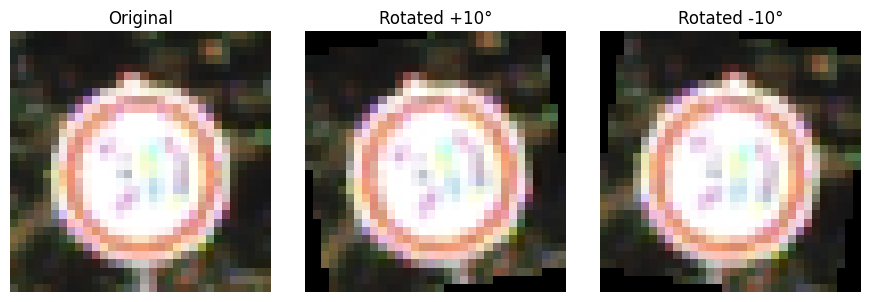

In [19]:
os.makedirs('./examples', exist_ok=True)
index = 300  # you can change this to view another sample

# Display original and rotated images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

ax1.imshow(X_train[index].astype(np.uint8))
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(X_train_rotated_positive[index].astype(np.uint8))
ax2.set_title('Rotated +10°')
ax2.axis('off')

ax3.imshow(X_train_rotated_negative[index].astype(np.uint8))
ax3.set_title('Rotated -10°')
ax3.axis('off')

# Save figure as high-quality image
plt.tight_layout()
plt.savefig('./examples/Figure_original_rotated.jpg', dpi=300)
plt.show()


### Data preprocessing

#### Normalizing
Normalizing helps the network to converge faster. It makes it a lot easier for the optimizer to proceed numerically.
It is required to normalize the image data so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. It doesn't change the content of the images.

#### Single-channel images (e.g. grayscale)
I am using a single channel in my model, e.g. grayscale images instead of color ones. As Pierre Sermanet and Yann LeCun mentioned in [their paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), using color channels didn't seem to improve things a lot.

In [72]:
print("Normalizing image data ...")

# ✅ Normalize training data (scales pixels from 0–255 → 0–1)
X_train = np.array(X_train, dtype=np.float32)
X_train = (X_train - 128.0) / 128.0   # centered around 0, range ≈ [-1, 1]

print("✅ Training data normalized. Shape:", X_train.shape)

Normalizing image data ...
✅ Training data normalized. Shape: (13230, 32, 32, 3)


In [73]:
print("Converting training images to grayscale ...")

# Convert RGB (32x32x3) → Grayscale (32x32x1)
X_train_gray = np.sum(X_train / 3, axis=3, keepdims=True)

print("✅ Conversion complete!")
print("Original X_train shape:", X_train.shape)
print("New grayscale X_train shape:", X_train_gray.shape)

# Replace X_train with grayscale version 
X_train = X_train_gray


Converting training images to grayscale ...
✅ Conversion complete!
Original X_train shape: (13230, 32, 32, 3)
New grayscale X_train shape: (13230, 32, 32, 1)


Random image index: 6895
image.shape  --> (32, 32)
image.size   --> 1024
image.dtype  --> float32
image.min()  --> -1.0
image.max()  --> 0.9921875


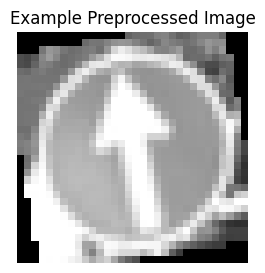

In [74]:
# Pick a random image index
index = random.randint(0, len(X_train) - 1)
image = X_train[index].squeeze() 

# Display image info
print("Random image index:", index)
print("image.shape  -->", image.shape)
print("image.size   -->", image.size)
print("image.dtype  -->", image.dtype)
print("image.min()  -->", np.min(image))
print("image.max()  -->", np.max(image))

# Display image
plt.figure(figsize=(3, 3))
plt.imshow(image, cmap="gray")   # 'gray' colormap for single-channel images
plt.title("Example Preprocessed Image")
plt.axis("off")
plt.show()


----

## Step 2: Design a Model Architecture (Deep Learning model)

In [75]:
import tensorflow as tf

# Flatten replacement for TF2
from tensorflow.keras.layers import Flatten

def LeNet(x, mu, sigma, strides, strides_pool, keep_prob, n_classes):
    print("Input shape:", x.shape)

    # Layer 1: Convolutional (3x3x1 → 16 filters)
    conv1_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 1, 16), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=strides, padding='VALID') + conv1_b
    conv1   = tf.nn.relu(conv1)
    print("Shape after 1st convolution:", conv1.shape)

    # Pooling 1
    conv1 = tf.nn.max_pool2d(conv1, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 1st pooling:", conv1.shape)

    # Layer 2: Convolutional (3x3x16 → 64 filters)
    conv3_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 16, 64), mean=mu, stddev=sigma))
    conv3_b = tf.Variable(tf.zeros(64))
    conv3   = tf.nn.conv2d(conv1, conv3_W, strides=strides, padding='VALID') + conv3_b
    conv3   = tf.nn.relu(conv3)
    print("Shape after 2nd convolution:", conv3.shape)

    # Pooling 2
    conv3 = tf.nn.max_pool2d(conv3, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 2nd pooling:", conv3.shape)

    # Layer 3: Convolutional (3x3x64 → 256 filters)
    conv5_W = tf.Variable(tf.random.truncated_normal(shape=(3, 3, 64, 256), mean=mu, stddev=sigma))
    conv5_b = tf.Variable(tf.zeros(256))
    conv5   = tf.nn.conv2d(conv3, conv5_W, strides=strides, padding='VALID') + conv5_b
    conv5   = tf.nn.relu(conv5)
    print("Shape after 3rd convolution:", conv5.shape)

    # Pooling 3
    conv5 = tf.nn.max_pool2d(conv5, ksize=[1, 2, 2, 1], strides=strides_pool, padding='VALID')
    print("Shape after 3rd pooling:", conv5.shape)

    # Flatten
    fc0 = Flatten()(conv5)
    print("Shape after flatten:", fc0.shape)

    # Fully Connected Layer 1 (1024 → 120)
    fc1_W = tf.Variable(tf.random.truncated_normal(shape=(1024, 120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1   = tf.nn.relu(fc1)
    print("Shape after first FC:", fc1.shape)

    # Dropout
    fc1 = tf.nn.dropout(fc1, rate=1 - keep_prob)
    print("Shape after dropout:", fc1.shape)

    # Fully Connected Layer 2 (120 → n_classes)
    fc2_W = tf.Variable(tf.random.truncated_normal(shape=(120, n_classes), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    print("Shape after output layer:", logits.shape)

    return logits


## Step 3: Train and Evaluate the model

### Tuning hyperparameters
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [76]:
EPOCHS = 50 # tells TensorFlow how many times to run our training data through the network
# in general the more epochs, the better our model will train but also the longer training will take.

BATCH_SIZE = 128 # tells TensorFlow how many training images to run through the network at a time
# the larger the batch size, the faster our model will train, but our processor may have a memory limit on how large a batch
# it can run

rate = 0.0005 # tells TensorFlow how quickly to update the network's weights; 0.001 is a good default value but can be experimented with
mu = 0 # used in tf.truncated_normal() --> see the model architecture LeNet() below
sigma = 0.1 # dito

# strides 's'. These are passed into LeNet()
strides = [1, 1, 1, 1] # [batch, y_direction, x_direction, input_channels]
strides_pool = [1, 2, 2, 1] # dito

# Dropout technique
keep_prob = 0.7

### Features and Labels

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels (groundtruth data).

In [77]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Input placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, 1), name='x')  # input images
y = tf.placeholder(tf.int32, (None), name='y')               # label indices

# One-hot encode the labels
one_hot_y = tf.one_hot(y, 43, name='one_hot_y')

print("✅ Placeholders and one-hot encoding initialized.")


✅ Placeholders and one-hot encoding initialized.


### Training pipeline
`training_operation`

In [78]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


n_classes = 43  # number of traffic sign classes
logits = LeNet(x, mu, sigma, strides, strides_pool, keep_prob, n_classes)

# ----------------------------------------------------------
# Define loss and optimizer
# ----------------------------------------------------------

# Cross-entropy loss between predicted logits and true labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)

# Average the cross-entropy across the batch
loss_operation = tf.reduce_mean(cross_entropy)

# Adam optimizer for backpropagation
optimizer = tf.train.AdamOptimizer(learning_rate=rate)

# Minimize the loss (this is what updates weights)
training_operation = optimizer.minimize(loss_operation)

print("✅ Model graph, loss function, and optimizer initialized successfully.")


Input shape: (?, 32, 32, 1)
Shape after 1st convolution: (?, 30, 30, 16)
Shape after 1st pooling: (?, 15, 15, 16)
Shape after 2nd convolution: (?, 13, 13, 64)
Shape after 2nd pooling: (?, 6, 6, 64)
Shape after 3rd convolution: (?, 4, 4, 256)
Shape after 3rd pooling: (?, 2, 2, 256)
Shape after flatten: (?, 1024)
Shape after first FC: (?, 120)
Shape after dropout: (?, 120)
Shape after output layer: (?, 43)
✅ Model graph, loss function, and optimizer initialized successfully.


### Evaluation pipeline

Evaluate the accuracy of the model.

In [79]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Compare predicted class 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))

# Compute mean accuracy across all examples in the batch
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Create a Saver object to save and restore model checkpoints
saver = tf.train.Saver()

# ---------------------------------------------------------
# Define evaluation function
# ---------------------------------------------------------
def evaluate(X_data, y_data):
    """
    Evaluate model accuracy on the given dataset using batches.
    """
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_examples


### Train the model

Run the training data through the training pipeline to train the model -->`training_operation`

Before each epoch, training set will be shuffled to ensure that training is not biased by the order of the images.

After each epoch, the accuracy on the training set is measured.

The model will be saved after training.

In [80]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training started...\n")
    for i in range(EPOCHS):
        # Shuffle training data each epoch
        X_train, y_train = shuffle(X_train, y_train)
        
        # Train on mini-batches
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        # Evaluate model on training data after each epoch
        training_accuracy = evaluate(X_train, y_train)
        
        print("EPOCH {} ...".format(i + 1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print()
    
    # Save trained model
    saver = tf.train.Saver()
    saver.save(sess, './lenet')
    print("✅ Model saved successfully as 'lenet'")


Training started...

EPOCH 1 ...
Training Accuracy = 0.311

EPOCH 2 ...
Training Accuracy = 0.567

EPOCH 3 ...
Training Accuracy = 0.727

EPOCH 4 ...
Training Accuracy = 0.814

EPOCH 5 ...
Training Accuracy = 0.871

EPOCH 6 ...
Training Accuracy = 0.913

EPOCH 7 ...
Training Accuracy = 0.931

EPOCH 8 ...
Training Accuracy = 0.946

EPOCH 9 ...
Training Accuracy = 0.963

EPOCH 10 ...
Training Accuracy = 0.962

EPOCH 11 ...
Training Accuracy = 0.965

EPOCH 12 ...
Training Accuracy = 0.969

EPOCH 13 ...
Training Accuracy = 0.978

EPOCH 14 ...
Training Accuracy = 0.982

EPOCH 15 ...
Training Accuracy = 0.984

EPOCH 16 ...
Training Accuracy = 0.984

EPOCH 17 ...
Training Accuracy = 0.985

EPOCH 18 ...
Training Accuracy = 0.988

EPOCH 19 ...
Training Accuracy = 0.979

EPOCH 20 ...
Training Accuracy = 0.987

EPOCH 21 ...
Training Accuracy = 0.988

EPOCH 22 ...
Training Accuracy = 0.991

EPOCH 23 ...
Training Accuracy = 0.994

EPOCH 24 ...
Training Accuracy = 0.995

EPOCH 25 ...
Training Accura

## Step 3: Use the model to make predictions on new images 

## Example 1: 

🧹 TensorFlow graph reset. Starting clean session...
✅ Selected image: C:/Users/HP/OneDrive/Desktop/python files/Traffic-Sign-Classifier-main_train/test_examples/002553.png

🧾 Preprocessing check:
  Shape: (1, 32, 32, 1)
  Min: -0.8984375
  Max: 0.9921875
  Mean: -0.4056015


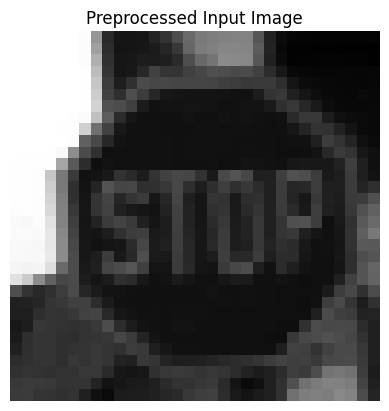


🔄 Restoring trained model...
✅ Model restored from: ./lenet

✅ Prediction Complete:
🧠 Predicted Class ID: 14
🏷  Predicted Label: Stop
📈 Confidence: 99.64%

Top-2 Predictions:
   1. Stop                           → 99.64%
   2. No vehicles                    → 0.36%


In [95]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os
from skimage import io
from tkinter import Tk
from tkinter.filedialog import askopenfilename

tf.reset_default_graph()
print("🧹 TensorFlow graph reset. Starting clean session...")

# ------------------------------------------------------------------
# 🖼 Step 1: Let user pick an image
# ------------------------------------------------------------------
Tk().withdraw()  # hide root window
image_path = askopenfilename(
    title="Select a traffic sign image",
    filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")]
)
if not image_path:
    raise SystemExit("❌ No image selected. Exiting.")
print(f"✅ Selected image: {image_path}")

# ------------------------------------------------------------------
#  Step 2: Preprocess image (same as training)
# ------------------------------------------------------------------
image = io.imread(image_path)
image_resized = cv2.resize(image, (32, 32))
if image_resized.ndim == 3:
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
else:
    gray = image_resized

# Normalization: match training (range [-1, +1])
normalized = (gray.astype(np.float32) - 128.0) / 128.0
X_single = normalized.reshape(1, 32, 32, 1)

print("\n🧾 Preprocessing check:")
print("  Shape:", X_single.shape)
print("  Min:", np.min(X_single))
print("  Max:", np.max(X_single))
print("  Mean:", np.mean(X_single))

# Show the processed image
plt.imshow(gray, cmap="gray")
plt.title("Preprocessed Input Image")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------
# 🧠 Step 3: Restore trained model
# ------------------------------------------------------------------
ckpt = tf.train.latest_checkpoint("./")
if not ckpt:
    raise FileNotFoundError("❌ No TensorFlow checkpoint found in current directory!")

with tf.Session() as sess:
    print("\n🔄 Restoring trained model...")
    saver = tf.train.import_meta_graph("lenet.meta")
    saver.restore(sess, ckpt)
    print(f"✅ Model restored from: {ckpt}")

    graph = tf.get_default_graph()

    # ------------------------------------------------------------------
    # Detect input tensor 
    # ------------------------------------------------------------------
    placeholders = [op for op in graph.get_operations() if "Placeholder" in op.type]
    x = None
    for p in reversed(placeholders):
        t = graph.get_tensor_by_name(p.name + ":0")
        if t.shape.ndims == 4 and t.dtype == tf.float32:
            x = t

            break
    if x is None:
        raise KeyError("❌ No valid input placeholder found.")
    
    logits_name = None
    for op in reversed(graph.get_operations()):
        n = op.name.lower()
        if ("add" in n or "matmul" in n) and not any(
            skip in n for skip in ["gradients", "adam", "loss", "softmax_cross_entropy"]
        ):
            logits_name = op.name
            break
    logits = graph.get_tensor_by_name(logits_name + ":0")

    global_vars = tf.global_variables()
    is_init = sess.run([tf.is_variable_initialized(v) for v in global_vars])
    uninit_vars = [v for v, init in zip(global_vars, is_init) if not init]
    if uninit_vars:
        print("\n⚙️ Initializing missing variables:")
        sess.run(tf.variables_initializer(uninit_vars))

    # ------------------------------------------------------------------
    # ⚙️ Step 4: Run inference
    # ------------------------------------------------------------------

    softmax_probs = tf.nn.softmax(logits)
    pred_idx, probs, logit_values = sess.run(
        [tf.argmax(softmax_probs, 1), softmax_probs, logits],
        feed_dict={x: X_single}
    )

# ------------------------------------------------------------------
# 📈 Step 5: Display predictions
# ------------------------------------------------------------------
signnames = pd.read_csv("signnames.csv")
id_to_name = dict(zip(signnames.ClassId, signnames.SignName))

pred_label = int(pred_idx[0])
pred_name = id_to_name.get(pred_label, f"Class {pred_label}")
confidence = np.max(probs) * 100

print("\n✅ Prediction Complete:")
print(f"🧠 Predicted Class ID: {pred_label}")
print(f"🏷  Predicted Label: {pred_name}")
print(f"📈 Confidence: {confidence:.2f}%")

# Show top-2 predictions
print("\nTop-2 Predictions:")
top2 = np.argsort(probs[0])[::-1][:2]
for i, idx in enumerate(top2):
    label = id_to_name.get(idx, f"Class {idx}")
    print(f"   {i+1}. {label:30s} → {probs[0][idx]*100:.2f}%")


(Running the same code used above to show different predictions)

## Example 2: 

🧹 TensorFlow graph reset. Starting clean session...
✅ Selected image: C:/Users/HP/OneDrive/Desktop/python files/Traffic-Sign-Classifier-main_train/test_examples/223055.png

🧾 Preprocessing check:
  Shape: (1, 32, 32, 1)
  Min: -1.0
  Max: 0.9921875
  Mean: 0.4914093


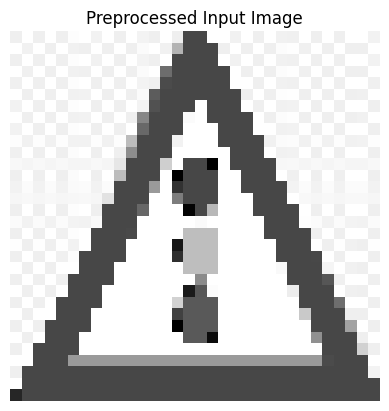


🔄 Restoring trained model...
✅ Model restored from: ./lenet

✅ Prediction Complete:
🧠 Predicted Class ID: 18
🏷  Predicted Label: General caution
📈 Confidence: 99.96%

Top-2 Predictions:
   1. General caution                → 99.96%
   2. Traffic signals                → 0.04%


In [90]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os
from skimage import io
from tkinter import Tk
from tkinter.filedialog import askopenfilename

tf.reset_default_graph()
print("🧹 TensorFlow graph reset. Starting clean session...")

# ------------------------------------------------------------------
# 🖼 Step 1: Let user pick an image
# ------------------------------------------------------------------
Tk().withdraw()  # hide root window
image_path = askopenfilename(
    title="Select a traffic sign image",
    filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")]
)
if not image_path:
    raise SystemExit("❌ No image selected. Exiting.")
print(f"✅ Selected image: {image_path}")

# ------------------------------------------------------------------
#  Step 2: Preprocess image (same as training)
# ------------------------------------------------------------------
image = io.imread(image_path)
image_resized = cv2.resize(image, (32, 32))
if image_resized.ndim == 3:
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
else:
    gray = image_resized

# Normalization: match training (range [-1, +1])
normalized = (gray.astype(np.float32) - 128.0) / 128.0
X_single = normalized.reshape(1, 32, 32, 1)

print("\n🧾 Preprocessing check:")
print("  Shape:", X_single.shape)
print("  Min:", np.min(X_single))
print("  Max:", np.max(X_single))
print("  Mean:", np.mean(X_single))

# Show the processed image
plt.imshow(gray, cmap="gray")
plt.title("Preprocessed Input Image")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------
# 🧠 Step 3: Restore trained model
# ------------------------------------------------------------------
ckpt = tf.train.latest_checkpoint("./")
if not ckpt:
    raise FileNotFoundError("❌ No TensorFlow checkpoint found in current directory!")

with tf.Session() as sess:
    print("\n🔄 Restoring trained model...")
    saver = tf.train.import_meta_graph("lenet.meta")
    saver.restore(sess, ckpt)
    print(f"✅ Model restored from: {ckpt}")

    graph = tf.get_default_graph()

    # ------------------------------------------------------------------
    # Detect input tensor 
    # ------------------------------------------------------------------
    placeholders = [op for op in graph.get_operations() if "Placeholder" in op.type]
    x = None
    for p in reversed(placeholders):
        t = graph.get_tensor_by_name(p.name + ":0")
        if t.shape.ndims == 4 and t.dtype == tf.float32:
            x = t

            break
    if x is None:
        raise KeyError("❌ No valid input placeholder found.")
    
    logits_name = None
    for op in reversed(graph.get_operations()):
        n = op.name.lower()
        if ("add" in n or "matmul" in n) and not any(
            skip in n for skip in ["gradients", "adam", "loss", "softmax_cross_entropy"]
        ):
            logits_name = op.name
            break
    logits = graph.get_tensor_by_name(logits_name + ":0")

    global_vars = tf.global_variables()
    is_init = sess.run([tf.is_variable_initialized(v) for v in global_vars])
    uninit_vars = [v for v, init in zip(global_vars, is_init) if not init]
    if uninit_vars:
        print("\n⚙️ Initializing missing variables:")
        sess.run(tf.variables_initializer(uninit_vars))

    # ------------------------------------------------------------------
    # ⚙️ Step 4: Run inference
    # ------------------------------------------------------------------

    softmax_probs = tf.nn.softmax(logits)
    pred_idx, probs, logit_values = sess.run(
        [tf.argmax(softmax_probs, 1), softmax_probs, logits],
        feed_dict={x: X_single}
    )

# ------------------------------------------------------------------
# 📈 Step 5: Display predictions
# ------------------------------------------------------------------
signnames = pd.read_csv("signnames.csv")
id_to_name = dict(zip(signnames.ClassId, signnames.SignName))

pred_label = int(pred_idx[0])
pred_name = id_to_name.get(pred_label, f"Class {pred_label}")
confidence = np.max(probs) * 100

print("\n✅ Prediction Complete:")
print(f"🧠 Predicted Class ID: {pred_label}")
print(f"🏷  Predicted Label: {pred_name}")
print(f"📈 Confidence: {confidence:.2f}%")

# Show top-2 predictions
print("\nTop-2 Predictions:")
top2 = np.argsort(probs[0])[::-1][:2]
for i, idx in enumerate(top2):
    label = id_to_name.get(idx, f"Class {idx}")
    print(f"   {i+1}. {label:30s} → {probs[0][idx]*100:.2f}%")


## Example 3:

🧹 TensorFlow graph reset. Starting clean session...
✅ Selected image: C:/Users/HP/OneDrive/Desktop/python files/Traffic-Sign-Classifier-main_train/test_examples/154041.png

🧾 Preprocessing check:
  Shape: (1, 32, 32, 1)
  Min: -0.53125
  Max: 0.5546875
  Mean: -0.06011963


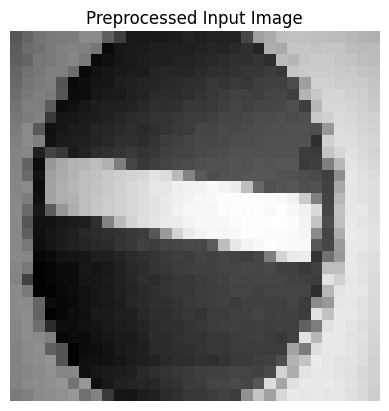


🔄 Restoring trained model...
✅ Model restored from: ./lenet

✅ Prediction Complete:
🧠 Predicted Class ID: 17
🏷  Predicted Label: No entry
📈 Confidence: 99.99%

Top-2 Predictions:
   1. No entry                       → 99.99%
   2. Yield                          → 0.01%


In [94]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, os
from skimage import io
from tkinter import Tk
from tkinter.filedialog import askopenfilename

tf.reset_default_graph()
print("🧹 TensorFlow graph reset. Starting clean session...")

# ------------------------------------------------------------------
# 🖼 Step 1: Let user pick an image
# ------------------------------------------------------------------
Tk().withdraw()  # hide root window
image_path = askopenfilename(
    title="Select a traffic sign image",
    filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")]
)
if not image_path:
    raise SystemExit("❌ No image selected. Exiting.")
print(f"✅ Selected image: {image_path}")

# ------------------------------------------------------------------
#  Step 2: Preprocess image (same as training)
# ------------------------------------------------------------------
image = io.imread(image_path)
image_resized = cv2.resize(image, (32, 32))
if image_resized.ndim == 3:
    gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
else:
    gray = image_resized

# Normalization: match training (range [-1, +1])
normalized = (gray.astype(np.float32) - 128.0) / 128.0
X_single = normalized.reshape(1, 32, 32, 1)

print("\n🧾 Preprocessing check:")
print("  Shape:", X_single.shape)
print("  Min:", np.min(X_single))
print("  Max:", np.max(X_single))
print("  Mean:", np.mean(X_single))

# Show the processed image
plt.imshow(gray, cmap="gray")
plt.title("Preprocessed Input Image")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------
# 🧠 Step 3: Restore trained model
# ------------------------------------------------------------------
ckpt = tf.train.latest_checkpoint("./")
if not ckpt:
    raise FileNotFoundError("❌ No TensorFlow checkpoint found in current directory!")

with tf.Session() as sess:
    print("\n🔄 Restoring trained model...")
    saver = tf.train.import_meta_graph("lenet.meta")
    saver.restore(sess, ckpt)
    print(f"✅ Model restored from: {ckpt}")

    graph = tf.get_default_graph()

    # ------------------------------------------------------------------
    # Detect input tensor 
    # ------------------------------------------------------------------
    placeholders = [op for op in graph.get_operations() if "Placeholder" in op.type]
    x = None
    for p in reversed(placeholders):
        t = graph.get_tensor_by_name(p.name + ":0")
        if t.shape.ndims == 4 and t.dtype == tf.float32:
            x = t

            break
    if x is None:
        raise KeyError("❌ No valid input placeholder found.")
    
    logits_name = None
    for op in reversed(graph.get_operations()):
        n = op.name.lower()
        if ("add" in n or "matmul" in n) and not any(
            skip in n for skip in ["gradients", "adam", "loss", "softmax_cross_entropy"]
        ):
            logits_name = op.name
            break
    logits = graph.get_tensor_by_name(logits_name + ":0")

    global_vars = tf.global_variables()
    is_init = sess.run([tf.is_variable_initialized(v) for v in global_vars])
    uninit_vars = [v for v, init in zip(global_vars, is_init) if not init]
    if uninit_vars:
        print("\n⚙️ Initializing missing variables:")
        sess.run(tf.variables_initializer(uninit_vars))

    # ------------------------------------------------------------------
    # ⚙️ Step 4: Run inference
    # ------------------------------------------------------------------

    softmax_probs = tf.nn.softmax(logits)
    pred_idx, probs, logit_values = sess.run(
        [tf.argmax(softmax_probs, 1), softmax_probs, logits],
        feed_dict={x: X_single}
    )

# ------------------------------------------------------------------
# 📈 Step 5: Display predictions
# ------------------------------------------------------------------
signnames = pd.read_csv("signnames.csv")
id_to_name = dict(zip(signnames.ClassId, signnames.SignName))

pred_label = int(pred_idx[0])
pred_name = id_to_name.get(pred_label, f"Class {pred_label}")
confidence = np.max(probs) * 100

print("\n✅ Prediction Complete:")
print(f"🧠 Predicted Class ID: {pred_label}")
print(f"🏷  Predicted Label: {pred_name}")
print(f"📈 Confidence: {confidence:.2f}%")

# Show top-2 predictions
print("\nTop-2 Predictions:")
top2 = np.argsort(probs[0])[::-1][:2]
for i, idx in enumerate(top2):
    label = id_to_name.get(idx, f"Class {idx}")
    print(f"   {i+1}. {label:30s} → {probs[0][idx]*100:.2f}%")
